In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gudhi as gd
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from scipy.stats import zscore
%matplotlib inline
import matplotlib
import seaborn as sns
import scipy.spatial.distance as ds
sns.set()
sns.set_context("talk", font_scale = 1.5)
sns.set_style('whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 7]

In [2]:
size = 30  # size of the 2D grid
dx = 2./ size  # space step

In [3]:
T = 9.0  # total time
dt = .3  # time step
n = int(T / dt)  # number of iterations

In [4]:
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

In [5]:
def RD_Model(D,R):
    U = np.random.rand(size, size)
    V = np.random.rand(size, size)

    Us = []

    for i in range(n):
        # We compute the Laplacian of u and v.
        deltaU = laplacian(U)
        deltaV = laplacian(V)
        # We take the values of u and v inside the grid.
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # We update the variables.
        U[1:-1, 1:-1], V[1:-1, 1:-1] = \
            Uc + dt * (D*deltaU) + R*(Vc - Uc),\
            Vc + dt * (D*deltaV) + R*(Uc - Vc)
        # Neumann conditions
        for Z in (U, V):
            Z[0, :] = Z[1, :]
            Z[-1, :] = Z[-2, :]
            Z[:, 0] = Z[:, 1]
            Z[:, -1] = Z[:, -2]
    
        Uz = np.array(U)
        
        Us.append(Uz)
        
    return np.stack(Us)


In [6]:
# define filtration range and increments
numPoints = 1000;
filtrationStart = 0;
filtrationEnd = 1;
filtrations = np.linspace(filtrationStart,filtrationEnd,numPoints);

# function returns an euler characteristic curve for a given image
def getEC(data):
    cubeplex = gd.CubicalComplex(dimensions  = [np.shape(data)[0],np.shape(data)[1],np.shape(data)[2]],top_dimensional_cells=np.ndarray.flatten(data));
    cubeplex.compute_persistence();
    b = np.zeros( (numPoints,3) ) ;
    ec = np.zeros(numPoints);
    for (i,fval) in enumerate(np.flip(filtrations)):
        betti = cubeplex.persistent_betti_numbers(fval,fval);
        b[i] = [betti[0], betti[1], betti[2]];
        ec[i] = betti[0] - betti[1] + betti[2];
    return ec;

In [7]:
#Select Diffusion (D) and Reaction (R) Parameters
D = 3e-4
R = .8

#Num Sims
s = 30

In [8]:
U1 = []

for i in range(s):
    U1.append(RD_Model(D,R))

In [9]:
U2 = []

for i in range(s):
    U2.append(RD_Model(D,.5*R))

In [10]:
U3 = []

for i in range(s):
    U3.append(RD_Model(2*D,R))

In [11]:
fft1 = []
fft2 = []
fft3 = []

for k in range(s):
    fft3.append(np.real(np.fft.fftn(U3[k])).flatten())
                
for k in range(s):
    fft2.append(np.real(np.fft.fftn(U2[k])).flatten())
                
for k in range(s):
    fft1.append(np.real(np.fft.fftn(U1[k])).flatten())

In [12]:
ec3 = []
ec2 = []
ec1 = []
ec4 = []

for k in tqdm(range(s)):
    ec3.append(getEC(U3[k]))
    
for k in tqdm(range(s)):
    ec2.append(getEC(U2[k]))
    
for k in tqdm(range(s)):
    ec1.append(getEC(U1[k]))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
ec3v = np.stack(ec3)
ec2v = np.stack(ec2)
ec1v = np.stack(ec1)

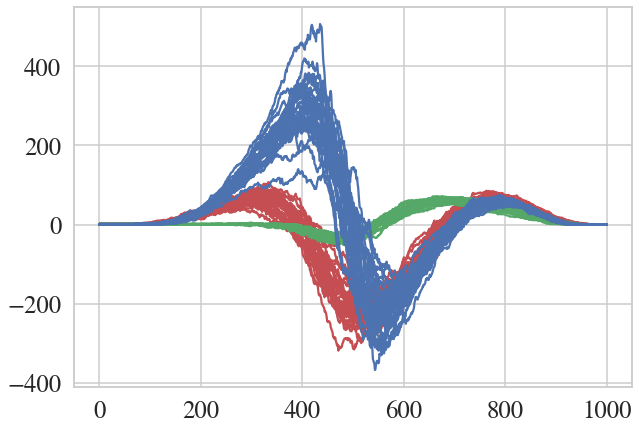

In [14]:
A = np.vstack([ec1,ec2,ec3])

for i in range(90):
    if i < 30:
        plt.plot(A[i,:],'r')
    elif i <  60:
        plt.plot(A[i,:],'g')
    else:
        plt.plot(A[i,:],'b')
        

Text(0.5, 0, 'Filtration')

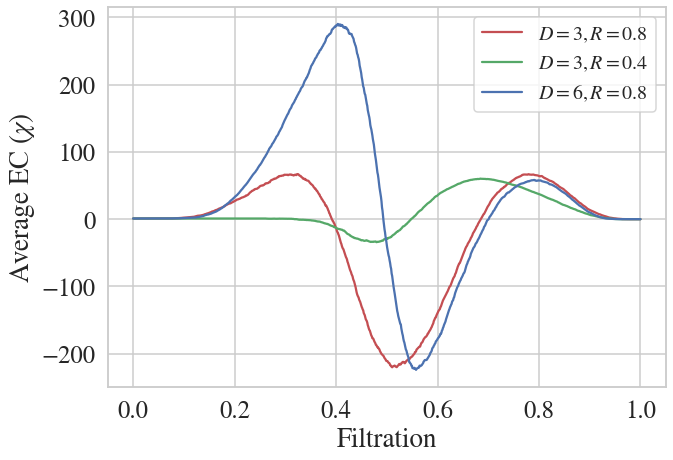

In [15]:
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
sns.set_style('whitegrid')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 7]

A1 = np.mean(A[0:30,:],axis = 0)
A2 = np.mean(A[30:60,:],axis = 0)
A3 = np.mean(A[60:90,:],axis = 0)
plt.plot(filtrations, A1, 'r',label = "$D=3,R=0.8$")
plt.plot(filtrations, A2, 'g', label = "$D=3,R=0.4$")
plt.plot(filtrations, A3, 'b',label = "$D=6,R=0.8$")

plt.legend(fontsize = 20)
plt.ylabel("Average EC ($\chi$)")
plt.xlabel("Filtration")

# plt.savefig('RDECs.pdf',transparent = True)

C:\Users\adsmith23\Anaconda3\lib\site-packages\scipy\stats\stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Text(0, 0.5, 'Principal Component 2')

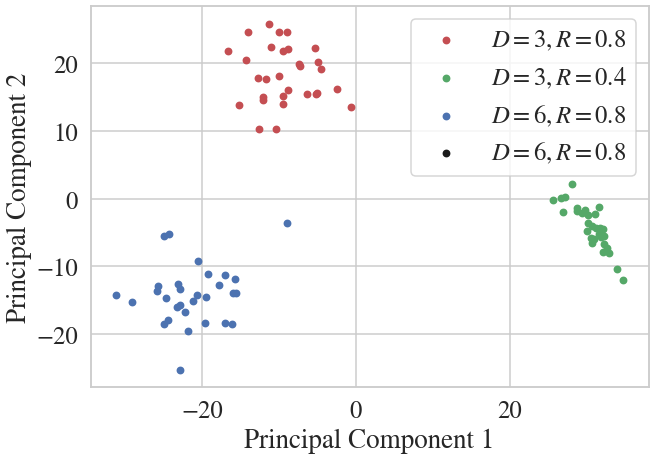

In [16]:
A = np.vstack([ec1,ec2,ec3])

pca = PCA()

X = pca.fit_transform(np.nan_to_num(zscore(A)))

plt.scatter(X[0:30,0],X[0:30,1],40,'r', label = "$D=3,R=0.8$")

plt.scatter(X[30:60,0],X[30:60,1],40,'g', label = "$D=3,R=0.4$")

plt.scatter(X[60:90,0],X[60:90,1],40,'b', label = "$D=6,R=0.8$")

plt.scatter(X[90::,0],X[90::,1],40,'k', label = "$D=6,R=0.8$")

plt.legend()

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# plt.savefig('RDECpca.pdf',transparent = True)

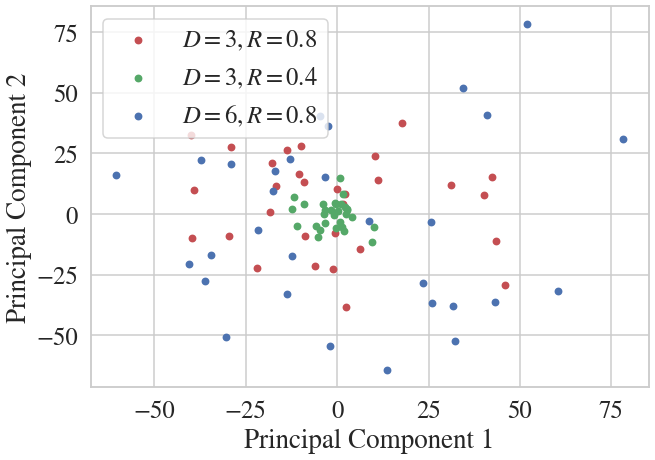

In [17]:
A = np.vstack([fft1,fft2,fft3])
np.shape(A)

pca = PCA()

X = pca.fit_transform(zscore(A))


plt.scatter(X[0:30,0],X[0:30,1],40,'r', label = "$D=3,R=0.8$")

plt.scatter(X[30:60,0],X[30:60,1],40,'g', label = "$D=3,R=0.4$")

plt.scatter(X[60::,0],X[60::,1],40,'b', label = "$D=6,R=0.8$")

plt.legend()

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.savefig('RDFTpca.pdf',transparent = True)

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
def make_ax(grid=True):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel(r"time ($t$)", labelpad=15)
    ax.set_ylabel(r"space ($x_1$)", labelpad=15)
    ax.set_zlabel(r"space ($x_2$)", labelpad=10)
    ax.grid(grid)
    return ax


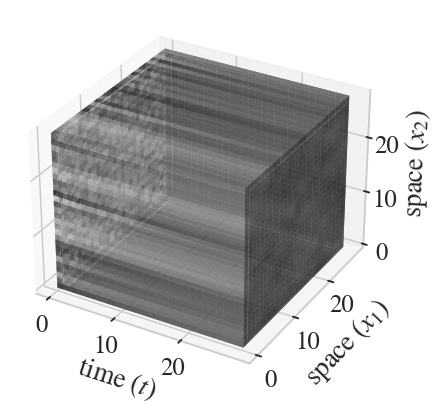

In [23]:
ax = make_ax()
facecolors = cm.gray(U1[10][1:29,1:29,1:29])
ax.voxels(np.ones((28, 28, 28)), facecolors=facecolors, linewidth = 0,alpha = .7)
plt.savefig("ST_cube110.pdf",transparent = True)

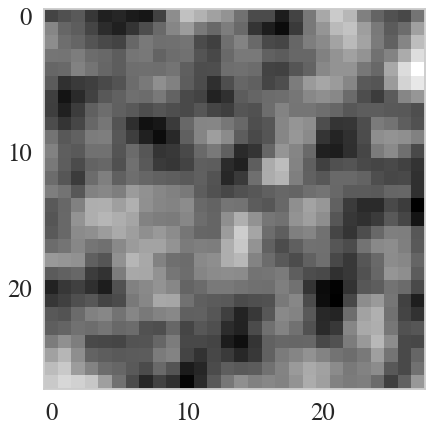

In [36]:
# sns.set()
# sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 7]

plt.imshow(U1[0][29][1:29,1:29],cmap = "gray")
plt.grid(False)

plt.gca().set_xticks([0,10,20])
plt.gca().set_yticks([0,10,20])

plt.savefig("st_snap130.svg",transparent = True)